# Clickbait Generator
Give me those clicks!!!
Data taken from https://github.com/bhargaviparanjape/clickbait

## Data Collection
1. Download source file
2. Extract archive

In [1]:
import os
import requests

In [2]:
data_file = "clickbait.gz"

def download_data():
    
    if os.path.exists(data_file):
        print("Found data file, not downloading")
        return
    
    print("Downloading data...")
    
    zip_file = requests.get("https://raw.githubusercontent.com/bhargaviparanjape/clickbait/master/dataset/clickbait_data.gz")

    with open(data_file, "wb+") as f:
        f.write(zip_file.content)
        

    

In [3]:
download_data()

Found data file, not downloading


## Data Processing
1. Extract archived data
2. Add end_of_headline terminator word
3. Tokenize titles
4. Split into X and Y data

In [85]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import gzip
import numpy as np

vocab_size = 10000
sample_length = 10
step = 2
end_of_headline = 'eoh'

In [86]:
def load_text():
    with gzip.open(data_file, 'rt') as f:
        return f.read().replace('\n\n', f" {end_of_headline} ")

def split_into_samples(text):
    samples = []
    next_words = []
    
    for i in range(0, len(text) - sample_length, step):
        samples.append(text[i:i + sample_length])
        next_words.append(text[i+sample_length])
    
    p = np.random.permutation(len(samples))
    return np.asarray(samples)[p], np.asarray(next_words)[p]

In [87]:
np.random.seed(0)

text = load_text()

tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts([text])
text = tokenizer.texts_to_sequences([text])[0]
X, Y = split_into_samples(text)

print(f"{len(tokenizer.word_index)} total words")
print(f"{len(X)} samples")
Y = to_categorical(Y, num_classes=vocab_size)


12113 total words
87134 samples


## LSTM Model
Uses GloVe word embeddings

In [88]:
import matplotlib.pyplot as plt
import tensorflow.keras
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Dropout
from tensorflow.keras.models import Model

In [98]:
def get_embedding_weights(tokenizer):
    # code based on Deep Learning with Python, 6.1.3
    glove_file = 'glove.6B.100d.txt'
    
    embedding_index = {}
    
    with open(glove_file) as f:
        for line in f:
            values = line.split()
            word = values[0]
            embedding_index[word] = np.asarray(values[1:], dtype='float32')
            
    embedding_dim = 100 # should match glove filename
    
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    
    not_found = []
    
    for word, i in tokenizer.word_index.items():
        if i < vocab_size:
            embedding_vector = embedding_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
                continue

            # try common 's and plural endings
            word = word.replace('\'s', '')
            embedding_vector = embedding_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
                continue

            if word.endswith('s'):
                word = word[:-1]
                embedding_vector = embedding_index.get(word)
                if embedding_vector is not None:
                    embedding_matrix[i] = embedding_vector
                    continue
                
            not_found.append(word)
                
    print(f"Not found: {len(not_found)}\n{not_found}")
                
    return embedding_matrix

In [99]:
embedding_weights = get_embedding_weights(tokenizer)

Not found: 371
['eoh', "you're", "you'll", "that'll", "you've", "don't", "didn't", "can't", "won't", "aren't", "they're", "i'm", 'selfie', "we're", 'emoji', "doesn't", "you'd", "isn't", "couldn't", "we'll", 'emoji', "shouldn't", "haven't", "kids'", "wouldn't", "we've", 'kylo', 'delevingne', 'cringeworthy', "wasn't", 'screencap', "styles'", "girls'", "who've", "weren't", 'selfie', "they've", "it'll", 'shamer', "freshers'", 'disick', 'boyega', 'shondaland', "celebrities'", "nyong'o", 'himym', 'instagrammed', "o'", 'nsfw', 'skyrim', 'furiosa', 'fuckboy', "characters'", 'fuckboy', "they'd", 'sweary', '5so', "i've", 'adulting', "lil'", "who'll", 'oitnb', 'swoonworthy', 'abuelita', 'pentatonix', 'photobombed', "girlfriends'", 'unsee', 'snapchatted', "he'd", "she'd", 'bellassai', 'batshit', 'fetty', 'oscarssowhite', 'blowingly', 'instafamou', "could've", 'germophobe', "parents'", "freakin'", 'retweeted', 'purrfect', 'burtka', 'shoutyourabortion', 'falkor', 'blaxican', 'bodypump', 'healthyish'

In [102]:
def create_model(sample_length, vocab_size, embedding_weights):
    input_layer = Input(shape=(sample_length,))
    
    m = Embedding(vocab_size, 100, input_length=sample_length)(input_layer)
    m = LSTM(256, dropout=0.5, recurrent_dropout=0.5, return_sequences=True)(m)
    m = LSTM(256, dropout=0.5, recurrent_dropout=0.5)(m)
    m = Dense(500, activation='relu')(m)
    m = Dropout(0.5)(m)
    m = Dense(vocab_size, activation='softmax')(m)
    
    model = Model(inputs=[input_layer], outputs=m)
    
    model.layers[1].set_weights([embedding_weights])
    model.layers[1].trainable = False
    
    return model

def make_plots(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(1, len(acc) + 1)
    
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Accuracy')
    plt.legend()
    
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Loss')
    plt.legend()
    
    plt.show()

In [103]:
model = create_model(sample_length, vocab_size, embedding_weights)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 10, 100)           1000000   
_________________________________________________________________
lstm_8 (LSTM)                (None, 10, 256)           365568    
_________________________________________________________________
lstm_9 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dense_8 (Dense)              (None, 500)               128500    
_________________________________________________________________
dropout_4 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 10000)             5010

In [104]:
history = model.fit(X, Y, batch_size=200, epochs=15, validation_split=0.05)
# model.save_weights('model.h5')

Train on 82777 samples, validate on 4357 samples
Epoch 1/20
82777/82777 [==============================] - 87s 1ms/sample - loss: 6.8016 - accuracy: 0.0905 - val_loss: 6.5376 - val_accuracy: 0.0936
Epoch 2/20
82777/82777 [==============================] - 85s 1ms/sample - loss: 6.5282 - accuracy: 0.0986 - val_loss: 6.2302 - val_accuracy: 0.1203
Epoch 3/20
82777/82777 [==============================] - 87s 1ms/sample - loss: 6.1874 - accuracy: 0.1228 - val_loss: 5.9562 - val_accuracy: 0.1373
Epoch 4/20
82777/82777 [==============================] - 89s 1ms/sample - loss: 5.9448 - accuracy: 0.1352 - val_loss: 5.7818 - val_accuracy: 0.1554
Epoch 5/20
82777/82777 [==============================] - 89s 1ms/sample - loss: 5.7516 - accuracy: 0.1487 - val_loss: 5.6674 - val_accuracy: 0.1657
Epoch 6/20
82777/82777 [==============================] - 91s 1ms/sample - loss: 5.5927 - accuracy: 0.1597 - val_loss: 5.5631 - val_accuracy: 0.1815
Epoch 7/20
82777/82777 [==============================] -

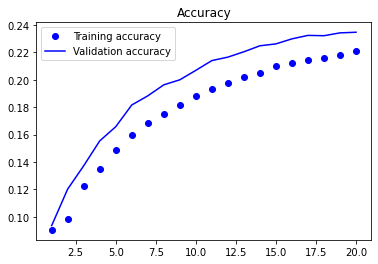

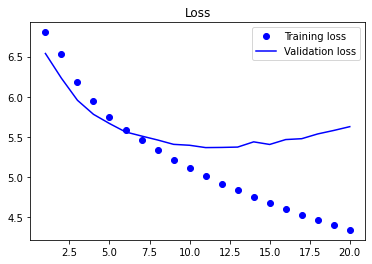

In [149]:
make_plots(history)

## Prediction

In [116]:
# temperature sampling based on Deep Learning book
def sample(preds, temperature):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probs = np.random.multinomial(1, preds, 1)
    return np.argmax(probs)

def generate_seq(model, tokenizer, seq_length, seed_text, n_words, temperature = 0.5):
    result = seed_text.split()
    in_text = seed_text
    # generate a fixed number of words
    for _ in range(n_words):
        # encode the text as integer
        encoded = tokenizer.texts_to_sequences([in_text])[0]
        # truncate sequences to a fixed length
        encoded = pad_sequences([encoded], maxlen=seq_length, truncating='pre')
        # predict probabilities for each word
        preds = model.predict(encoded, verbose=0)
        yhat = sample(preds[0], temperature)
        # map predicted word index to word
        out_word = 'X'
        for word, index in tokenizer.word_index.items():
            if index == yhat:
                out_word = word
                break
        if out_word == end_of_headline:
            break
        # append to input
        in_text += ' ' + out_word
        result.append(out_word)
    return ' '.join(result)

In [148]:
for i in range(0,10):
    output = generate_seq(model, tokenizer, sample_length, "", 20, .5)
    print(f"{i} {output}")

0 a man had the most way that happened when you have a friends
1 this is what happens when you ate in a first time
2 why to make your favorite crush day
3 are you more like at the actor from the first time
4 a blanket
5 is the most underrated thing you've ever seen
6 is the best way you've ever take
7 this is what i with your best friend
8 the best thing to say about you
9 how much do you remember the first time


## Results
My favorite results so far
- we know your zodiac sign based on your zodiac sign
- are you more like more dog or a dog
- the 17 most important canadian celebrity moments of 2015
- this is what it's like when you have a boyfriend
- the new best thing you've ever been
- are you more best or the most mermaid
- this is what it's like to be a best of the world
- these women are actually super
- here's how to make a vampire
- can you guess your favorite '90s movie based on your favorite kitten
- are you more a canadian or taylor swift or oprah